Idea from https://towardsdatascience.com/price-impact-of-order-book-imbalance-in-cryptocurrency-markets-bf39695246f6

### Data Preprosessing

In [3]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('20200130.SPY.csv')
data = data.apply(pd.to_numeric, errors='coerce')
#dtype={'a1p':float,'a2p':float,'a3p':float,'a4p':float,'a5p':float,'b1p':float, 'b2p':float,'b3p':float,'b4p':float,'b5p':float,'a1s':int,'a2s':int,'a3s':int,'a4s':int,'a5s':int, 'b1s':int,'b2s':int,'b3s':int,'b4s':int,'b5s':int})

c:\users\dylan\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
data['level_1'] = (data.b1s + data.a1s)/(data.b1s + data.a1s.abs())
data['level_2'] = (data.b1s + data.b2s + data.a1s + data.a2s)/(data.b1s + \
                  data.b2s + data.a1s.abs() + data.a2s.abs())
data['level_3'] = (data.b1s + data.b2s + data.b3s + data.a1s + data.a2s + data.a3s)/ \
                  (data.b1s + data.b2s + data.b3s + data.a1s.abs() + data.a2s.abs() \
                  + data.a3s.abs())
data['level_4'] = (data.b1s + data.b2s + data.b3s + data.b4s + \
                  data.a1s + data.a2s + data.a3s + data.a4s)/ \
                  (data.b1s + data.b2s + data.b3s + data.b4s + \
                   data.a1s.abs() + data.a2s.abs() + data.a3s.abs() + data.a4s.abs())
data['level_5'] = (data.b1s + data.b2s + data.b3s + data.b4s + data.b5s + \
                  data.a1s + data.a2s + data.a3s + data.a4s + data.a5s)/ \
                  (data.b1s + data.b2s + data.b3s + data.b4s + data.b5s + \
                   data.a1s.abs() + data.a2s.abs() + data.a3s.abs() + data.a4s.abs() + data.a5s.abs())                             

In [6]:
data['bid_1_change'] = data.b1p - data.b1p.shift(1)
data['ask_1_change'] = data.a1p - data.a1p.shift(1)

In [7]:
data['last_ticker'] = (data.Nanoseconds != data.Nanoseconds.shift(-1))

In [8]:
data["bid_minus_ask"] = data.b1p - data.a1p

In [9]:
data.tail()

,Unnamed: 0,Nanoseconds,Timestamp,a1p,a1s,a1o,a2p,a2s,a2o,a3p,...,b5o,level_1,level_2,level_3,level_4,level_5,bid_1_change,ask_1_change,last_ticker,bid_minus_ask
2223889,2223889,61192863291320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,False,NaN
2223890,2223890,61192863291320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,True,NaN
2223891,2223891,61192386502905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.01,NaN,False,NaN
2223892,2223892,61192386502905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.02,NaN,False,NaN
2223893,2223893,61192386502905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


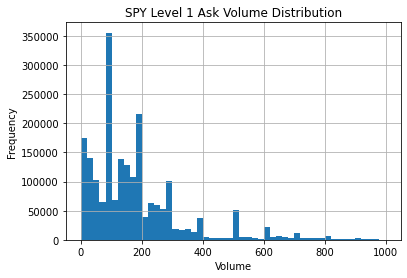

In [10]:
hplot = data.loc[data.a1s < 1000].hist(column='a1s', bins=50, )
for ax in hplot.flatten():
    ax.set_xlabel("Volume")
    ax.set_ylabel("Frequency")
    ax.set_title("SPY Level 1 Ask Volume Distribution")

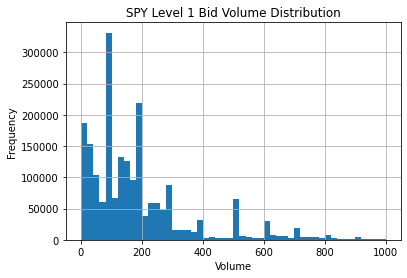

In [11]:
hplot = data.loc[data.b1s < 1000].hist(column='b1s', bins=50)
for ax in hplot.flatten():
    ax.set_xlabel("Volume")
    ax.set_ylabel("Frequency")
    ax.set_title("SPY Level 1 Bid Volume Distribution")

### Implement order imbalance strategy

In [108]:
def strategy(spread=0,latency=0,volume=0):
    
    max_hold = 100000
    n = len(data)
    
    print(f'Starting parameters... ${spread} / {latency}ns / {volume}')
    print(f'{n} rows of data to process')
    
    #start_time = datetime.now()
    buy = False
    sell = False
    trades = {}
    counter = 0
    stage = 0
    entry_time = 0
    exit_time = 0

    for i in range(n):
        
        if i % 200000 == 0:
            if i != 0:
                elapsed = (data.Nanoseconds[i] - 28800013717272)/1000000000;
                print(f'{len(trades)} trades made in {math.floor(elapsed/60)} minutes clock time')
                

        # LOOKING
        if stage == 0:
            if data.level_5[i] == 1:
                entry_detect = data.Nanoseconds[i]
                entry_time = entry_detect + latency                
                price = data.a1p[i] 
                buy=True
                stage = 1
                continue

            elif data.level_5[i] == -1:
                entry_detect = data.Nanoseconds[i]
                entry_time = entry_detect + latency
                price = data.b1p[i]
                sell=True
                stage = 1
                continue
                
        # WAITING
        elif stage == 1:
               
            if (data.Nanoseconds[i] >= entry_time):   

                if ((data.Nanoseconds[i] - entry_time) > max_hold):
                    
                    buy=False
                    sell=False
                    stage = 0
                    continue

                else:

                    if buy:
                        #if data.a1s[i] > volume:
                        if price <= data.a1p[i]:
                            entry_time = data.Nanoseconds[i]
                            exit_time = entry_time + max_hold
                            price = data.a1p[i]
                            stage = 2
                            continue

                    if sell:
                        #if data.b1p[i] > volume:
                        if price >= data.b1p[i]:
                            entry_time = data.Nanoseconds[i]
                            exit_time = entry_time + max_hold
                            price = data.b1p[i]
                            stage = 2
                            continue
            
        # EXIT
        elif stage == 2:
                                              
            #check expired trades
            
            if (data.Nanoseconds[i] > exit_time):

                if buy:
                    #if data.a1s[i] > volume:
                    new_trade = {'entry_time':entry_time, 'exit_time':data.Nanoseconds[i], 'buy':buy, 'sell':sell, 'entry_price':price, 'exit_price':data.a1p[i], 'change':data.bid_1_change[i], 'entry_detect':entry_detect, 'exit_detect':data.Nanoseconds[i], 'expired': True}
                    trades[counter] = new_trade
                    counter=counter+1
                    buy=False
                    stage = 0
                    continue

                if sell:
                    #if data.b1p[i] > volume:
                    new_trade = {'entry_time':entry_time, 'exit_time':data.Nanoseconds[i], 'buy':buy, 'sell':sell, 'entry_price':price, 'exit_price':data.b1p[i], 'change':data.ask_1_change[i], 'entry_detect':entry_detect, 'exit_detect':data.Nanoseconds[i], 'expired': True}   
                    trades[counter] = new_trade
                    counter=counter+1
                    sell=False
                    stage = 0
                    continue


            if (data.Nanoseconds[i] > entry_time):

                if buy:                                             
                    if (data.a1p[i] - price) > spread:
                        new_trade = {'entry_time':entry_time, 'exit_time':data.Nanoseconds[i] , 'buy':buy, 'sell':sell, 'entry_price':price, 'exit_price':data.a1p[i], 'change':data.bid_1_change[i], 'entry_detect':entry_detect, 'exit_detect':data.Nanoseconds[i], 'expired': False }   
                        trades[counter] = new_trade
                        counter=counter+1
                        buy=False
                        stage = 0
                        continue

                if sell:                        
                    if (price - data.b1p[i]) > spread:
                        new_trade = {'entry_time':entry_time, 'exit_time':data.Nanoseconds[i] , 'buy':buy, 'sell':sell, 'entry_price':price, 'exit_price':data.b1p[i], 'change':data.ask_1_change[i], 'entry_detect':entry_detect, 'exit_detect':data.Nanoseconds[i], 'expired': False }   
                        trades[counter] = new_trade
                        counter=counter+1
                        sell=False
                        stage = 0
                        continue
                
    return trades

# Simulation

Enter parameters in the code block below this.

In [115]:
VOL=50
trades = strategy(0.00,100000,VOL)

Starting parameters... $0.0 / 100000ns / 50
2223894 rows of data to process
4112 trades made in 103 minutes clock time
9039 trades made in 129 minutes clock time
13684 trades made in 161 minutes clock time
18902 trades made in 191 minutes clock time
24183 trades made in 228 minutes clock time
29657 trades made in 278 minutes clock time
34895 trades made in 320 minutes clock time
39966 trades made in 385 minutes clock time
45352 trades made in 410 minutes clock time
49874 trades made in 440 minutes clock time
55261 trades made in 479 minutes clock time


In [116]:
df = pd.DataFrame.from_dict(trades, "index")
df['duration'] = df.exit_time - df.entry_time
df['entry_wait'] = df.entry_time - df.entry_detect
df['exit_wait'] = df.exit_time - df.exit_detect
df.loc[df['buy'], 'profit'] = df.exit_price - df.entry_price
df.loc[df['sell'], 'profit'] = df.entry_price - df.exit_price

In [117]:
p = VOL*np.cumsum(df.profit)
print(f'TRADES: {len(p)}')
print(f'PROFIT: ${p.at[len(p)-1]}')

TRADES: 55317
PROFIT: $-275.4999999998972


55317


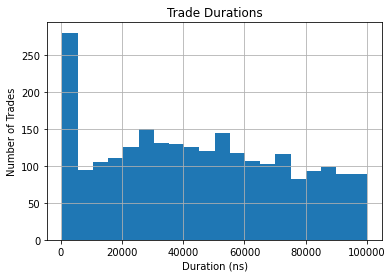

In [118]:
print(len(df.loc[df.duration > 100000 & df.expired]))
hplot = df.loc[df.duration < 100000].hist(column='duration', bins=20)
for ax in hplot.flatten():
    ax.set_xlabel("Duration (ns)")
    ax.set_ylabel("Number of Trades")
    ax.set_title("Trade Durations")

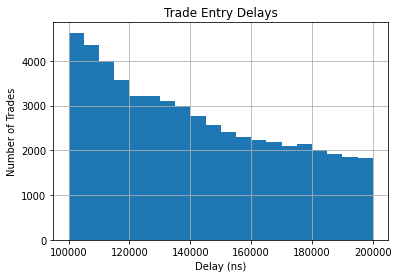

In [119]:
hplot = df.hist(column='entry_wait', bins=20)
for ax in hplot.flatten():
    ax.set_xlabel("Delay (ns)")
    ax.set_ylabel("Number of Trades")
    ax.set_title("Trade Entry Delays")

TRADES: 55317
PROFIT: $-275.4999999998972


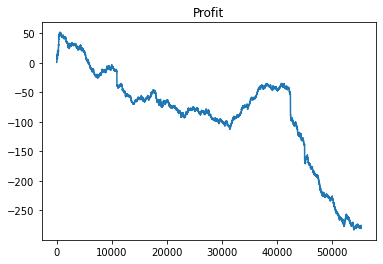

In [120]:
print(f'TRADES: {len(p)}')
print(f'PROFIT: ${p.at[len(p)-1]}')
#fig = plt.figure(figsize=(24, 10))
plt.title('Profit')
plt.plot(range(len(p)),p)
plt.show()

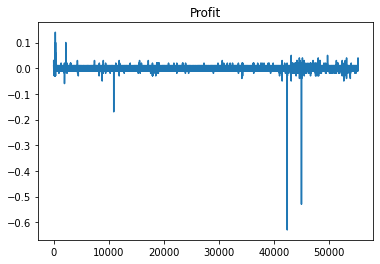

In [121]:
#fig = plt.figure(figsize=(24, 10))
plt.title('Profit')
plt.plot(range(len(df)),df.profit)
plt.show()

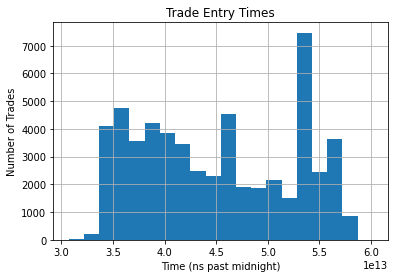

In [122]:
hplot = df.hist(column='entry_time', bins=20)
for ax in hplot.flatten():
    ax.set_xlabel("Time (ns past midnight)")
    ax.set_ylabel("Number of Trades")
    ax.set_title("Trade Entry Times")

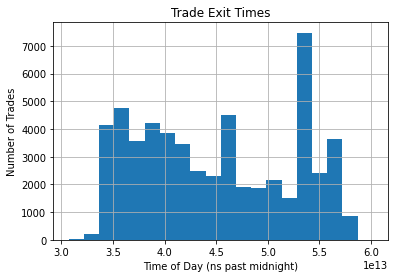

In [123]:
hplot = df.hist(column='exit_time', bins=20)
for ax in hplot.flatten():
    ax.set_xlabel("Time of Day (ns past midnight)")
    ax.set_ylabel("Number of Trades")
    ax.set_title("Trade Exit Times")